Esta celda importa las librerías necesarias utilizadas en el notebook: Scikit-learn, Pandas, NumPy, Optuna, Matplotlib, Seaborn, imblearn, Streamlit y joblib.

In [89]:
import sklearn
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import streamlit as st
import joblib

Carga el dataset desde el archivo `stroke_dataset.csv` y muestra las primeras filas para inspección inicial.

In [90]:
df = pd.read_csv("stroke_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


Muestra información básica del dataframe (info, descripción estadística y conteo de valores nulos) para detectar problemas y entender la estructura.

In [91]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   str    
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   str    
 5   work_type          4981 non-null   str    
 6   Residence_type     4981 non-null   str    
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   str    
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), str(5)
memory usage: 428.2 KB


gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Cuenta y muestra la distribución de la variable objetivo `stroke`, tanto absoluta como relativa.

In [92]:
df['stroke'].value_counts()
df['stroke'].value_counts(normalize=True)

stroke
0    0.950211
1    0.049789
Name: proportion, dtype: float64

Visualiza la distribución de la edad por clase `stroke` con un diagrama de caja (boxplot).

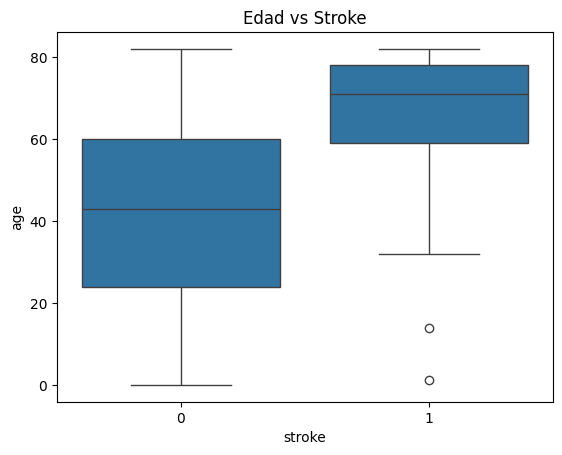

In [93]:
sns.boxplot(x="stroke", y="age", data=df)
plt.title("Edad vs Stroke")
plt.show()

Cuenta y visualiza la variable `hypertension` diferenciando por la etiqueta `stroke` usando un gráfico de barras.

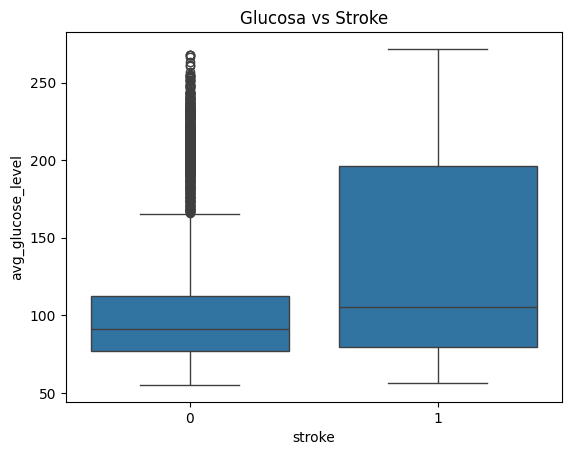

In [94]:
sns.boxplot(x="stroke", y="avg_glucose_level", data=df)
plt.title("Glucosa vs Stroke")
plt.show()

Compara la distribución del nivel medio de glucosa (`avg_glucose_level`) entre las clases con un boxplot.

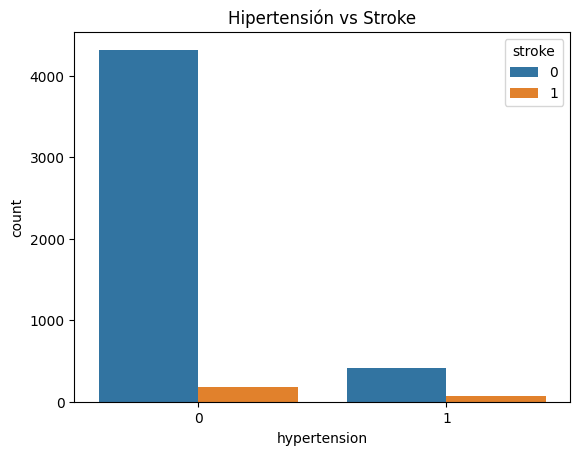

In [95]:
sns.countplot(x="hypertension", hue="stroke", data=df)
plt.title("Hipertensión vs Stroke")
plt.show()

Muestra un mapa de calor con las correlaciones entre las variables numéricas del dataframe.

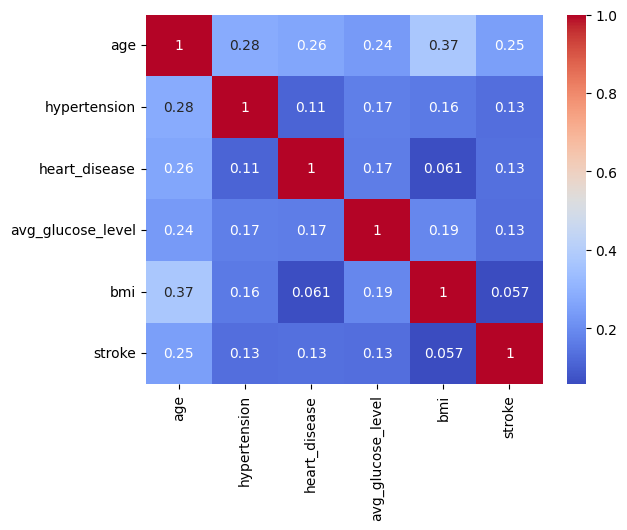

In [96]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()

Elimina las filas con género 'Other' para simplificar el análisis y evitar valores atípicos o raros.

In [77]:
df = df[df["gender"] != "Other"]
df.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
5,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
6,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
7,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
8,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
9,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1


Convierte variables categóricas en dummies (one-hot encoding) y elimina una columna para evitar multicolinealidad (`drop_first=True`).

In [78]:
df = pd.get_dummies(df, drop_first=True)

Separa las features (`X`) de la variable objetivo (`y`) preparando los datos para el modelado.

In [79]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

Divide el conjunto en entrenamiento y prueba (`train_test_split`) con estratificación para mantener la proporción de clases.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Entrena un modelo de regresión logística con los datos de entrenamiento y realiza predicciones sobre el conjunto de prueba.

In [81]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Imprime métricas de evaluación del modelo (reporte de clasificación, matriz de confusión y ROC AUC) para evaluar rendimiento.

In [82]:

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       947
           1       0.00      0.00      0.00        50

    accuracy                           0.95       997
   macro avg       0.47      0.50      0.49       997
weighted avg       0.90      0.95      0.93       997

[[947   0]
 [ 50   0]]
ROC AUC: 0.5


c:\Users\USUARIO\Desktop\factoriaf5\p_final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USUARIO\Desktop\factoriaf5\p_final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USUARIO\Desktop\factoriaf5\p_final\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

Aplica SMOTE para balancear las clases en el conjunto de entrenamiento y vuelve a entrenar el modelo con los datos re-muestreados.

In [83]:

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

model.fit(X_train_res, y_train_res)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

Entrena un `RandomForestClassifier` (con ajuste de clase) y realiza predicciones sobre el conjunto de prueba.

In [84]:
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

Calcula e muestra la importancia de las características del modelo Random Forest, ordenadas de mayor a menor.

In [85]:
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).head(10)

age                               0.379594
avg_glucose_level                 0.202934
bmi                               0.180463
hypertension                      0.036610
ever_married_Yes                  0.031979
Residence_type_Urban              0.024626
gender_Male                       0.024531
smoking_status_never smoked       0.020229
work_type_Private                 0.020196
smoking_status_formerly smoked    0.018273
dtype: float64

Evalúa el modelo Random Forest con validación cruzada (5 folds) usando la métrica `recall` y muestra la media de los scores.

In [86]:
scores = cross_val_score(rf, X, y, cv=5, scoring="recall")
print(scores.mean())

0.0


Configura una búsqueda en malla (`GridSearchCV`) para optimizar hiperparámetros del Random Forest usando `recall` como métrica.

In [87]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(rf, param_grid, cv=5, scoring="recall")
grid.fit(X_train, y_train)

grid.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}

Interfaz Streamlit: carga (si existe) un modelo serializado `modelo.pkl` y proporciona controles para ingresar `Edad` y `Nivel de glucosa` y realizar predicciones.

In [98]:
import os

if not os.path.exists("modelo.pkl"):
    st.error("archivo 'modelo.pkl' no encontrado. Entrene y guarde el modelo primero.")
else:
    model = joblib.load("modelo.pkl")

    st.title("Predicción de Ictus")

    age = st.number_input("Edad")
    glucose = st.number_input("Nivel de glucosa")

    if st.button("Predecir"):
        prediction = model.predict([[age, glucose, ...]])
        st.write(prediction)

2026-02-26 12:42:39.190 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 12:42:39.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 12:42:39.192 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 12:42:39.193 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 12:42:39.194 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 12:42:39.195 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 12:42:39.198 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-26 12:42:39.199 Session state does not function when running a script without `streamlit run`
2026-02-26 12:42

In [97]:
# Guarda el mejor modelo disponible en 'modelo.pkl' para la interfaz Streamlit
import joblib

if 'grid' in globals() and hasattr(grid, 'best_estimator_'):
    best_model = grid.best_estimator_
elif 'rf' in globals():
    best_model = rf
elif 'model' in globals():
    best_model = model
else:
    best_model = None

if best_model is not None:
    joblib.dump(best_model, "modelo.pkl")
    print("Modelo guardado en 'modelo.pkl'")
else:
    print("No se encontró modelo para guardar.")

Modelo guardado en 'modelo.pkl'
